In [27]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (8, 6),        # Default figure size
    'font.size': 12,                # Font size for labels and titles
    'axes.titlesize': 14,           # Title font size
    'axes.labelsize': 12,           # Axis label font size
    'xtick.labelsize': 10,          # X-axis tick size
    'ytick.labelsize': 10,          # Y-axis tick size
    'axes.grid': True,              # Add grid by default
    'grid.alpha': 0.5,              # Make grid lines subtle
    'grid.linestyle': '--',         # Dashed grid lines
    'legend.fontsize': 10,          # Legend font size
    'legend.frameon': True,         # Box around the legend
    'legend.loc': 'best',           # Best location for the legend
    'savefig.dpi': 300,             # High-resolution saves
    'savefig.format': 'png',        # Default save format
    'lines.linewidth': 1.5,           # Thicker lines
    'lines.markersize': 6,          # Marker size
    "font.family": "serif",
})

#   plt.rcParams['figure.figsize'] = (8, 4)
pd.options.display.float_format = '{:.2f}'.format

In [28]:
def transform_results(data):
    result_list = []
    smapes = []
    for date, details in data.items():
        for auction, auction_data in details.get("auctions", {}).items():
            if auction_data.get("SMAPE", None) is not None:
                smapes.append(auction_data["SMAPE"])
            result = {
                "Date": date,
                "Auction": auction,
                "CVaR": auction_data.get("cvar", np.nan),
                "SMAPE (%)": auction_data.get("SMAPE", np.nan),
                "Net Volume": auction_data.get("net_volume_traded", np.nan),
                "Volume": auction_data.get("volume_traded", np.nan),
                "Profit": auction_data.get("profit", np.nan),
                "Expected Profit": auction_data.get("forecasted_profit", np.nan),
                "Profit Deviation": np.abs(auction_data.get("profit", 0) - auction_data.get("forecasted_profit", 0))
            }
            result_list.append(result)

    return pd.DataFrame(result_list)

In [29]:
def read_results(power, capacity, risk_averse_factor=None, year=2023):
    file = f'../../Results/{year}/results_battery={capacity}MWh;{power}MW_l={risk_averse_factor}.json'
    with open(file, 'r') as f:
        data = json.load(f)
    return transform_results(data)

### Model comparison


In [30]:
def get_models(power=10, capacity=20, year=2023, lambdas=[0, 0.25, 0.5, 0.75, 1], benchmark=True):
    models = {}
    for l in lambdas:
        models[f'\(\lambda={l}\)'] = read_results(power, capacity, l, year)
    if benchmark:
        models['Benchmark'] = read_results(power, capacity, None, year)
    return models

In [31]:
import pandas as pd

# Assuming `models` is structured like:
models = {
    year: get_models(lambdas=[0, 0.25, 0.5, 0.75, 1],
                     year=year, benchmark=False)
    for year in [2022, 2023]
}

# Generate the data for the table
data = {
    year: {
        # 'Profit': {model_name: model['Profit'].sum().sum() for model_name, model in models[year].items()},
        'Realized': {model_name: model.groupby('Date')['Profit'].sum().mean() for model_name, model in models[year].items()},
        'Expected': {model_name: model.groupby('Date')['Expected Profit'].sum().mean() for model_name, model in models[year].items()},
        'CVaR': {model_name: model.groupby('Date')['CVaR'].sum().mean() for model_name, model in models[year].items()},
        # 'Std.': {model_name: model.groupby('Date')['Profit'].sum().std() for model_name, model in models[year].items()},
        # 'Min. Profit' : {model_name: model.groupby('Date')['Profit'].sum().min() for model_name, model in models[year].items()}
    }
    for year in [2022, 2023]
}

# Convert the nested dictionary to a MultiIndex DataFrame
df = pd.concat(
    {year: pd.DataFrame(metrics) for year, metrics in data.items()},
    axis=1
)
df.columns.names = ["", "Model"]

df = df.map(lambda x: f"{x:,.0f}")
print(df.to_latex())
df

\begin{tabular}{lllllll}
\toprule
 & \multicolumn{3}{r}{2022} & \multicolumn{3}{r}{2023} \\
Model & Realized & Expected & CVaR & Realized & Expected & CVaR \\
\midrule
\(\lambda=0\) & 4,737 & 9,844 & 16,271 & 2,567 & 4,937 & 12,656 \\
\(\lambda=0.25\) & 4,824 & 8,776 & 5,024 & 2,628 & 4,494 & 2,426 \\
\(\lambda=0.5\) & 4,828 & 6,894 & 430 & 2,644 & 3,739 & 171 \\
\(\lambda=0.75\) & 4,828 & 6,725 & 30 & 2,689 & 3,767 & 21 \\
\(\lambda=1\) & 1,146 & 1,541 & 0 & 854 & 955 & 0 \\
\bottomrule
\end{tabular}



2022                      2023                 
Model            Realized Expected    CVaR Realized Expected    CVaR
\(\lambda=0\)       4,737    9,844  16,271    2,567    4,937  12,656
\(\lambda=0.25\)    4,824    8,776   5,024    2,628    4,494   2,426
\(\lambda=0.5\)     4,828    6,894     430    2,644    3,739     171
\(\lambda=0.75\)    4,828    6,725      30    2,689    3,767      21
\(\lambda=1\)       1,146    1,541       0      854      955       0

In [ ]:
model = models['\\(\\lambda=0.25\\)']
model.groupby('Date')

,Date,Auction,CVaR,SMAPE (%),Net Volume,Volume,Profit,Expected Profit,Profit Deviation
0,2023-01-01,DA,1287.48,16.74,-51.20,238.80,8891.85,12322.18,3430.33
1,2023-01-01,IDA1,4442.30,12.12,1.20,228.80,2787.54,6422.91,3635.37
2,2023-01-01,IDA2,0.00,7.99,50.00,80.00,-9229.35,-9411.33,181.98
3,2023-01-02,DA,357.74,25.33,25.74,235.74,-5303.07,2328.31,7631.37
4,2023-01-02,IDA1,212.85,25.81,-25.02,215.02,6630.53,3647.20,2983.32
...,...,...,...,...,...,...,...,...,...
1090,2023-12-30,IDA1,122.40,78.66,216.33,226.33,-18455.16,-32126.99,13671.83
1091,2023-12-30,IDA2,0.00,161.24,3.67,83.67,403.05,245.63,157.42
1092,2023-12-31,DA,228.68,44.15,20.72,239.28,2764.73,2845.76,81.03
1093,2023-12-31,IDA1,151.88,18.88,-16.66,193.34,-16.23,-72.22,56.00


In [79]:
data = {}
for year in [2022, 2023]:
    models = get_models(year=year, benchmark=False)

    data[year] = {
        'Profit/Mwh': {name: np.mean(model.groupby('Date')["Profit"].sum() / model.groupby('Date')["Volume"].sum()) for name, model in models.items()},
        'CVaR/Mwh': {name: np.mean(model.groupby('Date')["CVaR"].sum() / model.groupby('Date')["Volume"].sum()) for name, model in models.items()},
    }
    
df = pd.concat(
    {year: pd.DataFrame(metrics) for year, metrics in data.items()},
    axis=1
)
df.columns.names = ["", "Model"]
df = df.map(lambda x: f"{x:,.2f}")
df

2022                2023         
Model            Profit/Mwh CVaR/Mwh Profit/Mwh CVaR/Mwh
\(\lambda=0\)          8.78    30.08       4.79    23.57
\(\lambda=0.25\)       9.12     9.34       5.04     4.55
\(\lambda=0.5\)        9.34     0.80       5.18     0.32
\(\lambda=0.75\)       9.37     0.06       5.30     0.04
\(\lambda=1\)          2.18     0.00       1.65     0.00

\begin{tabular}{lllll}
\toprule
 & \multicolumn{2}{r}{2022} & \multicolumn{2}{r}{2023} \\
Model & Profit/Mwh & CVaR/Mwh & Profit/Mwh & CVaR/Mwh \\
\midrule
\(\lambda=0\) & 8.75 & 30.04 & 4.77 & 23.53 \\
\(\lambda=0.25\) & 9.12 & 9.49 & 5.01 & 4.62 \\
\(\lambda=0.5\) & 9.35 & 0.83 & 5.16 & 0.33 \\
\(\lambda=0.75\) & 9.38 & 0.06 & 5.29 & 0.04 \\
\(\lambda=1\) & 2.18 & 0.00 & 1.64 & 0.00 \\
\bottomrule
\end{tabular}



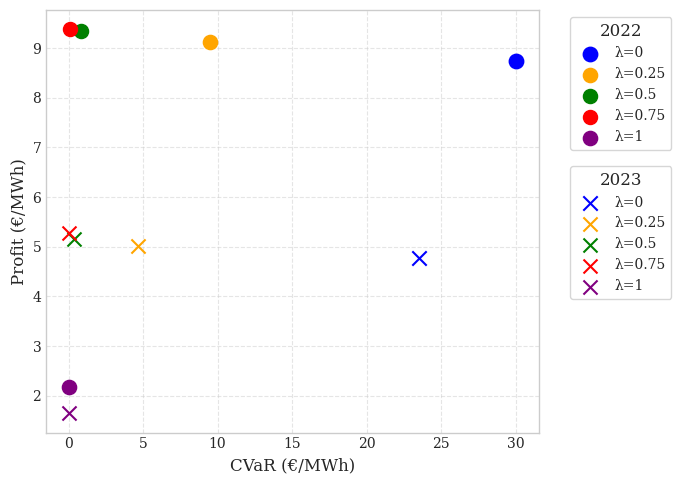

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

# Define colors for models
colors = {
    'λ=0': 'blue',
    'λ=0.25': 'orange',
    'λ=0.5': 'green',
    'λ=0.75': 'red',
    'λ=1': 'purple'
}
# Define markers for years
markers = {2022: 'o', 2023: 'x'}

# Separate handles for legends
handles_2022 = []
handles_2023 = []

data = {}
for year in [2022, 2023]:
    models = get_models(year=year, benchmark=False)
    for name, model in models.items():
        name = 'λ' + name.strip('\(\lambda\)')
        scatter = plt.scatter(
            model.groupby('Date')["CVaR"].sum().sum() /
            model.groupby('Date')["Volume"].sum().sum(),
            model.groupby('Date')["Profit"].sum().sum() /
            model.groupby('Date')["Volume"].sum().sum(),
            s=model.groupby('Date')["Volume"].sum().mean() // 5,
            color=colors[name],
            marker=markers[year],
            label=f"{name}"
        )
        # Add to respective legend handles
        if year == 2022:
            handles_2022.append(scatter)
        else:
            handles_2023.append(scatter)

    data[year] = {
        'Profit/Mwh': {name: model.groupby('Date')["Profit"].sum().sum() / model.groupby('Date')["Volume"].sum().sum() for name, model in models.items()},
        'CVaR/Mwh': {name: model.groupby('Date')["CVaR"].sum().sum() / model.groupby('Date')["Volume"].sum().sum() for name, model in models.items()}
    }

df = pd.concat(
    {year: pd.DataFrame(metrics) for year, metrics in data.items()},
    axis=1
)
df.columns.names = ["", "Model"]
df = df.map(lambda x: f"{x:,.2f}")
print(df.to_latex())

# Create separate legends for 2022 and 2023
legend_2022 = plt.legend(handles=handles_2022, title="2022",
                         loc='upper left', bbox_to_anchor=(1.05, 1))
plt.gca().add_artist(legend_2022)  # Add the 2022 legend to the plot

legend_2023 = plt.legend(handles=handles_2023, title="2023",
                         loc='lower left', bbox_to_anchor=(1.05, 0.3))

plt.xlabel('CVaR (€/MWh)')
plt.ylabel('Profit (€/MWh)')
plt.tight_layout()
plt.savefig(f'../../Data/Paper/Results/balance_separate_legends.png', dpi=300)
plt.show()

losses:
\begin{tabular}{llll}
\toprule
 & 0 & 1 & 2 \\
\midrule
λ=0 & 28 & -1640 & 1607 \\
λ=0.25 & 15 & -1452 & 1650 \\
λ=0.5 & 4 & -489 & 177 \\
λ=0.75 & 3 & -272 & 133 \\
λ=1 & 84 & -1044 & 1102 \\
Benchmark & 0 & nan & nan \\
\bottomrule
\end{tabular}



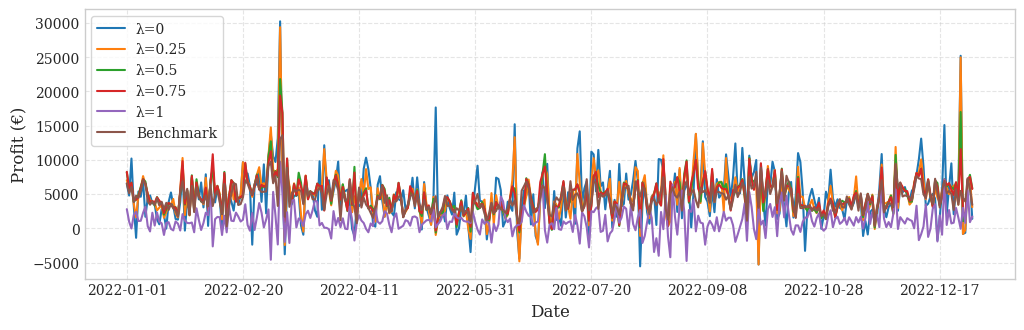

losses:
\begin{tabular}{llll}
\toprule
 & 0 & 1 & 2 \\
\midrule
λ=0 & 20 & -837 & 871 \\
λ=0.25 & 5 & -630 & 412 \\
λ=0.5 & 1 & -766 & nan \\
λ=0.75 & 1 & -130 & nan \\
λ=1 & 46 & -419 & 406 \\
Benchmark & 0 & nan & nan \\
\bottomrule
\end{tabular}



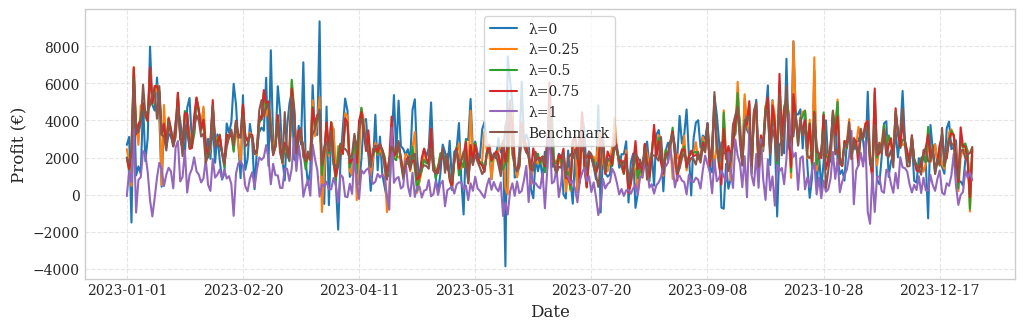

In [33]:
def plot_profits(year, ls=[0, 0.25, 0.5, 0.75, 1], include_benchmark=True):
    models = get_models(year=year, lambdas=ls, benchmark=include_benchmark)
    profits = {
        name.strip('\()').replace('lambda', 'λ'): model.groupby('Date')["Profit"].sum() for name, model in models.items()
    }
    profits = pd.DataFrame(profits)

    print("losses:")
    print(pd.DataFrame({model: (profits.loc[profits[model] < 0, model].count(), profits.loc[profits[model] < 0, model].mean(
    ), profits.loc[profits[model] < 0, model].std()) for model in profits.columns}).T.map(lambda x: f"{x:.0f}").to_latex())
    # print('\n',profits.idxmax())
    profits.plot(figsize=(12, 3.5))
    plt.xlabel('Date')
    plt.ylabel('Profit (€)')
    # plt.savefig(f'../../Data/Paper/Results/profits_visual_{year}.png', dpi=300)
    plt.show()


plot_profits(2022, ls=[0, 0.25, 0.5, 0.75, 1])
plot_profits(2023, ls=[0, 0.25, 0.5, 0.75, 1])

VOLUME


        Inter-Auction Trading (%)
λ=0                         33.78
λ=0.25                      17.96
λ=0.5                        5.06
λ=0.75                       4.19
λ=1                          7.06


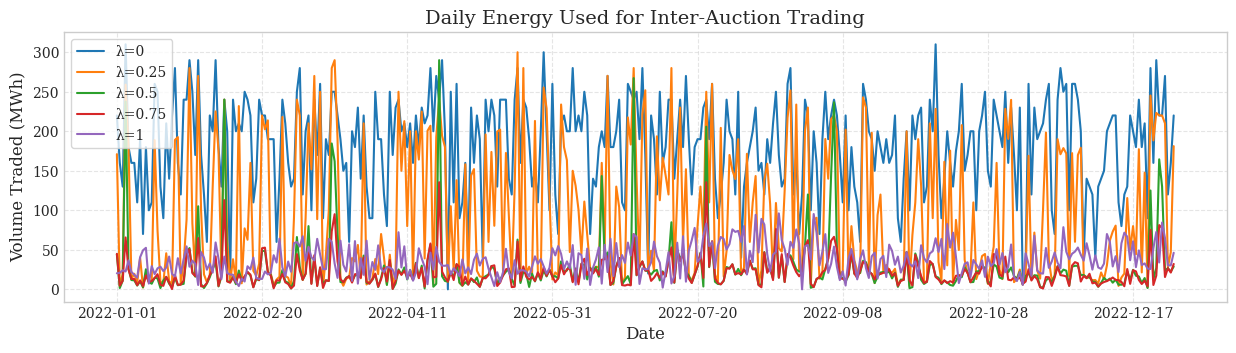

        Inter-Auction Trading (%)
λ=0                         34.36
λ=0.25                      15.73
λ=0.5                        5.31
λ=0.75                       4.07
λ=1                          6.71


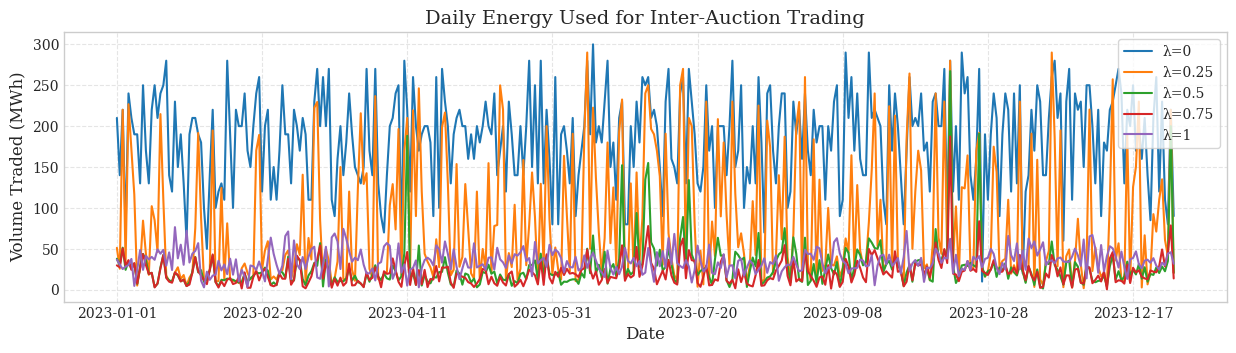

In [34]:


for year in [2022, 2023]:
    plt.figure(figsize=(15, 3.5))
    models = get_models(year=year)
    res = {}
    for name, model in models.items():
        if name == 'Benchmark':
            continue
        name = 'λ' + name.strip('\(\lambda\)')
        # Group by day and auction, then calculate net volume
        daily_auction_volume = model.groupby(['Date', 'Auction'])[
            'Net Volume'].sum()
        daily_auction_volume = daily_auction_volume.unstack(level='Auction')
        cumulative_volume = daily_auction_volume.cumsum(axis=1)
        inter_auction_trading = cumulative_volume.diff(
            axis=1).abs().sum(axis=1)
        res[name] = inter_auction_trading.sum() / model['Volume'].sum() * 100
        inter_auction_trading.plot(label=name)
    print(pd.DataFrame(res, index=['Inter-Auction Trading (%)']).T)
    plt.title("Daily Energy Used for Inter-Auction Trading")
    plt.xlabel("Date")
    plt.ylabel("Volume Traded (MWh)")
    plt.legend()
    plt.grid(True)
    plt.show()

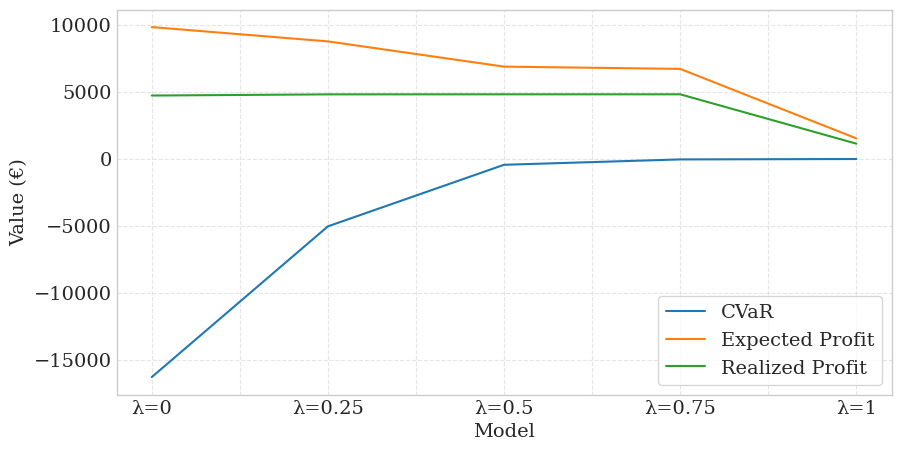

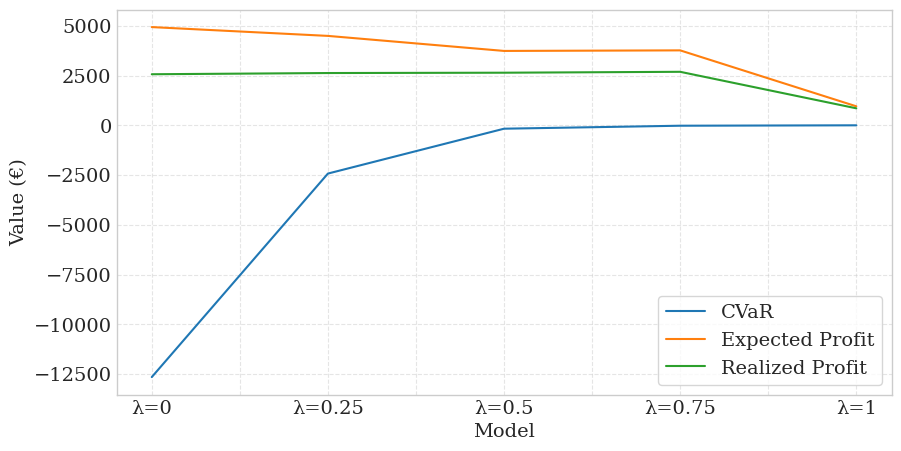

In [65]:
for year in [2022, 2023]:
    models = get_models(year=year)
    res = {}
    for name, model in models.items():
        if name == 'Benchmark':
            continue
        name = 'λ' + name.strip('\(\lambda\)')
        res[name] = [-model.groupby('Date')['CVaR'].sum().mean(), model.groupby('Date')[
            "Expected Profit"].sum().mean(), model.groupby('Date')["Profit"].sum().mean()]
    res = pd.DataFrame(
        res, index=['CVaR', 'Expected Profit', 'Realized Profit']).T
    res.plot()

    plt.gcf().set_size_inches(10, 5)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Value (€)', fontsize=14)
    plt.legend(loc='lower right', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(f'../../Data/Paper/Results/cvar_profit_{year}.png', dpi=300)
plt.show()